### Objetivos del notebook
---
En el presente notebook vamos a aprender a utilizar el algoritmo de XGBoost para trabajar con Series Temporales.

[XGBoost](https://xgboost.readthedocs.io/en/stable/) es una implementación muy popular del [Gradient Boosting](https://interactivechaos.com/es/manual/tutorial-de-machine-learning/gradient-boosting) y se ha convertido **"de facto"** en el benchmark a batir para datos tabulares.

A pesar de tener sus carencias para problemas de Series Temporales (por ejemplo: no es capaz de extrapolar una tendencia), el algoritmo es muy versátil y todo Data Scientist debe conocerlo. 

El dataset con el que vamos a trabajar en este notebook contiene alrededor de **300 Series Temporales** que abarcan el periodo Enero'2013 - Septiembre'2015. Por tanto vamos a trabajar con **Series Temporales Multivariante**.

Cada una de estas **Series Temporales** representan las ventas <u>**DIARIAS**</u> de **un artículo en un tienda y ciudad**. El objetivo es predecir las <u>**VENTAS TOTALES DEL MES DE OCTUBRE'2015**</u>.

Es decir, partimos de ventas diarias y vamos a tener que <u>**agrupar nuestras ventas por mes**</u> antes de crear variables o entrenar el modelo.

Al final del notebook, el alumno debe estar familiarizado con:

1. **La importancia de establecer un benchmark (CORE IDEA)** cuando empezamos a trabajar en un problema de Machine Learning. <br>
2. Saber utilizar **pandas de forma eficiente para manipular el dataset (resample de pandas, groupby etc).** <br>
3. **Combinar la información de diferentes Series Temporales para generar variables (ventas totales de un artículo, ventas totales de todos los artículos en una tienda) con las que alimentar nuestro modelo XGBoost (CORE IDEA).**<br>
4. **Saber identificar las variables autoexplicativas (COREA IDEA)** y sus principales causas.<br>
5. Comprender **la importancia de iterar rápido (realizar muchos experimentos) (CORE IDEA)** para testear diferentes hipótesis y variables que se construyen.

---

El presente notebook contiene muchas funcionalidades avanzadas que puede requerir varias lecturas para su comprensión.
Pensamos que las secciones marcadas con **CORE IDEA** son las que mayor beneficio le reportarán al alumno. Por este motivo, le animamos a que dedique especial atención a estas ideas.

Al final del notebook, hay un sección de referencias y lecturas recomendables para que el alumno pueda seguir profundizando en estos conceptos.

---

### Índice
<a id='index'></a>

[Imports del notebook](#imports_notebook)<br>
[Helpers Time Series](#helpers)<br>
[Data Loading](#data_load)<br>
[La idea del Benchmark (**CORE IDEA**)](#benchmark)<br>
[Agrupación de las ventas por mes (**CORE IDEA**)](#monthly_agg)<br>
[Data Imputation](#impute)<br>
[EDA](#eda)<br>
[--> 1. EDA: Global Sales](#eda_global_sales)<br>
[--> 2. EDA: Top 3 Cities](#eda_top_3_cities)<br>
[--> 3. EDA: Top 3 Categories](#eda_top_3_categories)<br>
[Build Time Series Features (**CORE IDEA**)](#build_ts_features)<br>
[Join TS Features](#join_ts_features)<br>
[Train Test Split](#train_test_split)<br>
[Model Train](#model_train)<br>
[Model Evaluation (**COREA IDEA**)](#model_evaluation)<br>
[Prediction](#prediction)<br>

### Conclusión
[Conclusión](#conclusion)<br>

### Referencias
[Referencias y lecturas recomendables](#referencias)<br>

<a id='imports_notebook'></a>
### Imports del notebook
[Volver al índice](#index)

En este apartado hacemos los principales imports del notebook.<br>
Sobre todo vamos a trabajar con **numpy**, **pandas**, **statsmodels** y **XGBoost**.

In [1]:
import pickle
import os

from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
print("Working with these versions of libraries\n")
print(f"Numpy version {np.__version__}")
print(f"Pandas version {pd.__version__}")
print(f"XGBoost version {xgb.__version__}")

Working with these versions of libraries

Numpy version 1.21.6
Pandas version 1.3.5
XGBoost version 1.6.2


In [4]:
# GLOBAL_VARIABLES
CWD = os.getcwd()
DATA_PATH = os.path.join(CWD, "data")
TRAIN_CSV_PATH = os.path.join(DATA_PATH, "/kaggle/input/nuclio16-dsc-1122/sales_train_merged.csv")

DATA_PATH = "/kaggle/input/nuclio16-dsc-1122"
TRAIN_CSV_PATH = os.path.join(DATA_PATH, "sales_train_merged.csv")

ORDER_COLUMNS = [
    'DATE',
    'UNIQUE_ID',
    'CITY_NAME',
    'CITY_ID',
    'SHOP_NAME',
    'SHOP_ID',
    'ITEM_CATEGORY_NAME',
    'ITEM_CATEGORY_ID',
    'ITEM_NAME',
    'ITEM_ID',
    'ITEM_PRICE',
    'SALES'
]

<a id='helpers'></a>
### Helpers Time Series
[Volver al índice](#index)

En este apartado definimos varias funciones auxiliares que utilizaremos a lo largo del notebook.

In [5]:
def load_data(path_data_file):
    '''
    Loads the csv file for training.
    '''
    df = pd.read_csv(path_data_file, index_col = 0)
    
    df = preprocess_df(df)
    
    return df

In [6]:
def preprocess_df(df):
    '''
    Preprocess df: upper columns, str date to datetime etc.
    '''
    df.columns = map(str.upper, df.columns)
    df["DATE"] = pd.to_datetime(df["DATE"], format = "%Y-%m-%d")
    
    df["CITY_ID"] = OrdinalEncoder().fit_transform(df[["CITY"]])
    
    df.rename(columns = {"CITY":"CITY_NAME", "ITEM_CNT_DAY":"SALES"}, inplace = True)
    df = df[ORDER_COLUMNS]
    
    return df

<a id='data_load'></a>
### Data Loading
[Volver al índice](#index)

Vamos a cargar nuestro dataset para comenzar con el EDA.

In [7]:
df = load_data(path_data_file = "/kaggle/input/nuclio16-dsc-1122/sales_train_merged.csv")
df.sample(5)

,DATE,UNIQUE_ID,CITY_NAME,CITY_ID,SHOP_NAME,SHOP_ID,ITEM_CATEGORY_NAME,ITEM_CATEGORY_ID,ITEM_NAME,ITEM_ID,ITEM_PRICE,SALES
24692,2013-12-17,47-20949,Surgut,15.0,"Surgut SEC ""City Mall""",47,"Regalos - Bolsas, álbumes, Mats d / ratón",71,Paquete corporativo Mike 1C Interés blanco (34...,20949,5.0,5.0
76430,2015-05-11,21-17717,Moscú,7.0,"Moscú MTRTS ""Afi Mall""",21,Herramientas de sistema,79,Recibir fondos para 1c-online,17717,500.0,1.0
23479,2013-12-30,28-7893,Moscú,7.0,"centro comercial de Moscú ""MEGA Teply Stan"" II",28,Accesorios - XBOX 360,6,X360: GamePad Wireless Black - Controlador ina...,7893,1790.0,1.0
71851,2015-03-17,52-20949,Ufa,19.0,"Ufa TC ""central""",52,"Regalos - Bolsas, álbumes, Mats d / ratón",71,Paquete corporativo Mike 1C Interés blanco (34...,20949,5.0,2.0
35815,2014-04-26,55-492,Tienda Online,16.0,El almacenamiento digital 1C-line,55,Programa - Hogar y Oficina (Digital),76,"1C: Money 8 Versión electrónica [PC, versión d...",492,600.0,1.0


Vamos a ver que tipo de datos tenemos en nuestro dataset.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87963 entries, 0 to 87962
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   DATE                87963 non-null  datetime64[ns]
 1   UNIQUE_ID           87963 non-null  object        
 2   CITY_NAME           87963 non-null  object        
 3   CITY_ID             87963 non-null  float64       
 4   SHOP_NAME           87963 non-null  object        
 5   SHOP_ID             87963 non-null  int64         
 6   ITEM_CATEGORY_NAME  87963 non-null  object        
 7   ITEM_CATEGORY_ID    87963 non-null  int64         
 8   ITEM_NAME           87963 non-null  object        
 9   ITEM_ID             87963 non-null  int64         
 10  ITEM_PRICE          87963 non-null  float64       
 11  SALES               87963 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(5)
memory usage: 8.7+ MB


<a id='benchmark'></a>
### La idea del Benchmark (CORE IDEA)
[Volver al índice](#index)

En el presente notebook buscamos establecer un benchmark rápido. 

El motivo fundamental es porque los datasets en la vida real son muy complejos y no tenemos el "lujo" de poder analizar todas y cada una de las variables <u>**ANTES DE ENTRENAR NUESTRO PRIMER MODELO.</u>**

Establecer un benchmark nos ayuda a entender cual es el punto de partida, es decir: <u>**cual es el score mínimo para este dataset.**</u>

Muchas veces este benchmark puede ser un modelo entrenado con unas pocas columnas númericas (imputando los nulos con la media). <u>**No se trata de tener el mejor modelo sino de entrenar nuestro primer modelo.**</u> 

Una vez sabemos cual es el punto de partida y tenemos un notebook **"funcional"** podemos empezar a experimentar con nuestro dataset. Por "notebook funcional" entendemos un script/notebook que podemos ejecutar en su totalidad (loading del dataset, preprocessing, train_test_split, train y predict). En cada experimento iremos añadiendo nuevas variables, diferentes imputaciones, modelos y vamos guardando el score que obtenemos. De este manera, podemos ver la contribución de cada variables y comprobar si estamos mejorando o no respecto al benchmark.

Dado que este notebook es un benchmark, tenemos que **"acotar"** muy bien las cosas que vamos a implementar (para no irnos por las ramas).

A **grosso modo** vamos a hacer las siguientes cosas:

1. Ver cuantas Series Temporales tenemos en el dataset.
2. Hacer un check de si tenemos todas las fechas históricas en el dataset.
3. Generar las fechas que puedan estar missing.
4. Tratar los nulos.
5. Crear algunas variables rápidas para el entrenamiento.
6. Entrenar el algoritmo.
7. Evaluar el modelo.
8. Hacer el submit a Kaggle.

Empecemos:

Tenemos un total de 299 Series Temporales en el dataset:

In [9]:
df["UNIQUE_ID"].nunique()

299

Veamos cuales son las fechas min y max de nuestro dataset:

In [10]:
MIN_DATE = df["DATE"].min()
MAX_DATE = df["DATE"].max()

In [11]:
print(f"Min date is {MIN_DATE}\nMax date is {MAX_DATE}")

Min date is 2013-01-01 00:00:00
Max date is 2015-09-30 00:00:00


In [12]:
date_range = pd.date_range(start=MIN_DATE, end=MAX_DATE, freq='M')
num_m = len(date_range)
print("El número de meses entre", MIN_DATE, "y", MAX_DATE, "es:", num_m)

El número de meses entre 2013-01-01 00:00:00 y 2015-09-30 00:00:00 es: 33


<a id='monthly_agg'></a>
### Agrupación de las ventas por mes
[Volver al índice](#index)

En esta competición nos piden que hagamos el predict de las ventas totales del mes de Octubre'2015 para cada ITEM_ID y SHOP_ID.

No obstante, si miramos el dataset con detenimiento, veremos que las ventas reportadas vienen por día. Ahora mismo tenemos 2 opciones: 

1. Podemos entrenar un modelo con las ventas diarias, predecir 30 días y luego sumar las 30 predicciones y obtener el valor para Octubre'2015.
2. Agrupar las ventas por mes, entrenar un modelo con las ventas mensuales y hacer 1 predict (mes de Octubre'2015).

Claramente la segunda opción es mucho más sencilla: básicamente me permite enfocar un problema de Series Temporales Multivariante como un problema de Regresión (1 predicción a futuro). Por este motivo vamos a seguir este enfoque.

Nota: Si observamos bien, UNIQUE_ID = SHOP_ID + ITEM_ID.

In [13]:
df.sample(5)

,DATE,UNIQUE_ID,CITY_NAME,CITY_ID,SHOP_NAME,SHOP_ID,ITEM_CATEGORY_NAME,ITEM_CATEGORY_ID,ITEM_NAME,ITEM_ID,ITEM_PRICE,SALES
82762,2015-07-01,31-21404,Moscú,7.0,"centro comercial de Moscú ""Semenov""",31,Película - DVD,40,Corazón frío m / f (región),21404,169.000000,1.0
41577,2014-06-09,24-20949,Moscú,7.0,"Moscú TK ""Budenovsky"" (pav.K7)",24,"Regalos - Bolsas, álbumes, Mats d / ratón",71,Paquete corporativo Mike 1C Interés blanco (34...,20949,5.000000,5.0
73142,2015-03-25,31-6457,Moscú,7.0,"centro comercial de Moscú ""Semenov""",31,Juegos PC - Standard Edition,30,"Simcity [PC, versión rusa]",6457,699.000000,2.0
58459,2014-11-06,16-20949,Kolomna,4.0,"centro comercial kolomna ""Río""",16,"Regalos - Bolsas, álbumes, Mats d / ratón",71,Paquete corporativo Mike 1C Interés blanco (34...,20949,5.000000,1.0
23334,2013-12-29,31-3331,Moscú,7.0,"centro comercial de Moscú ""Semenov""",31,Juegos PC - Standard Edition,30,"FIFA 14 [PC, versión rusa]",3331,798.833333,3.0


A continuación vamos a agrupar las ventas diarias por mes, en función de cada shop_id e item_id (groupby).

Dado que vamos a entrenar nuestro modelo con variables mensuales, aprovechamos la operación para constuir un total de 5 variables: 

1. Ventas totales
2. Ingresos totales (precio x cantidad)
3. Días únicos que tuvieron ventas
4. Total transacciones del mes 
5. Precio medio del mes

In [14]:
df["REVENUE"] = df["ITEM_PRICE"] * df["SALES"]   # 1. ventas totales (precio unidad por total de ventas)

df["UNIQUE_DAYS_WITH_SALES"] = df["DATE"]        # 3.dias unicos que tuvieron ventas 
df["TOTAL_TRANSACTIONS"] = df["SALES"]           # 4.Total de ventas
df['MONTHLY_MEAN_SALES'] = df["SALES"]          # 5.Precio medio del mes

En las clases anteriores hemos aprendido a utilizar el [pandas groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html).

Cuando trabajamos con Series Temporales y necesitamos agrupar las Series Temporales por día, semana, mes o año, podemos utilizar el groupby pero es mejor utilizar el [pandas resample](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html).

La síntaxis del pandas resample es muy sencilla, vamos a ver un ejemplo de como podríamos agrupar las ventas por semana.

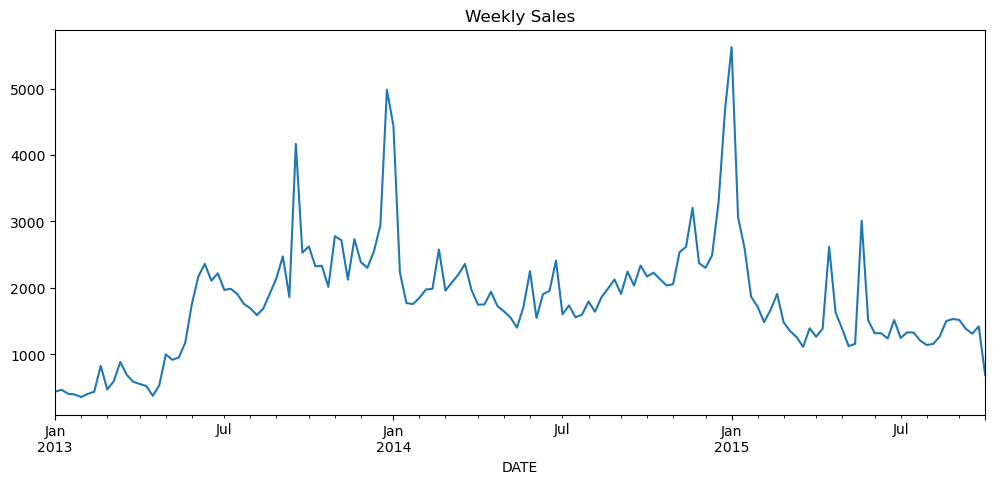

In [15]:
# Para utilizar el resample
# 1. La fecha debe estar en el índice
# 2. Debemos llamar el método resample y pasarle un regla:
#    D -> Daily
#    W -> Weekly
#    M -> Monthly
#    Y -> Yearly

df.set_index("DATE").resample("W")["SALES"].sum().plot(figsize = (12, 5), title = "Weekly Sales");

En el código anterior, hemos hecho el resample de todas las ventas.

Pero nosotros debemos tener en cuenta el item_id y el shop_id antes de hacer el resample.

Veamos como podemos combinar el groupby con resample.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87963 entries, 0 to 87962
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   DATE                    87963 non-null  datetime64[ns]
 1   UNIQUE_ID               87963 non-null  object        
 2   CITY_NAME               87963 non-null  object        
 3   CITY_ID                 87963 non-null  float64       
 4   SHOP_NAME               87963 non-null  object        
 5   SHOP_ID                 87963 non-null  int64         
 6   ITEM_CATEGORY_NAME      87963 non-null  object        
 7   ITEM_CATEGORY_ID        87963 non-null  int64         
 8   ITEM_NAME               87963 non-null  object        
 9   ITEM_ID                 87963 non-null  int64         
 10  ITEM_PRICE              87963 non-null  float64       
 11  SALES                   87963 non-null  float64       
 12  REVENUE                 87963 non-null  float6

In [17]:
# Implement in class

df_monthly_agg = df.set_index("DATE").groupby(["UNIQUE_ID"]).resample("M").agg(
    {
        "SALES":np.sum,
        "REVENUE":np.sum,
        "UNIQUE_DAYS_WITH_SALES":lambda dates: len(set(dates)),
        "TOTAL_TRANSACTIONS":len,
        "ITEM_PRICE":np.mean
    }
).rename(
    columns = {
        "SALES":"MONTHLY_SALES",
        "REVENUE":"MONTHLY_REVENUE",
        "ITEM_PRICE":"MONTHLY_MEAN_PRICE"
    }
).reset_index()

In [18]:
df_monthly_agg["CHECK"] = df_monthly_agg["UNIQUE_DAYS_WITH_SALES"] == df_monthly_agg["TOTAL_TRANSACTIONS"]

In [19]:
df_monthly_agg[df_monthly_agg["CHECK"] == False].sample(5)

,UNIQUE_ID,DATE,MONTHLY_SALES,MONTHLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,MONTHLY_MEAN_PRICE,CHECK
1514,24-2308,2013-04-30,6.0,4894.0,5,6,815.666667,False
1579,24-2808,2013-04-30,17.0,15833.0,9,11,963.015152,False
1545,24-2445,2013-03-31,59.0,70559.0,24,34,1196.325490,False
1578,24-2808,2013-03-31,14.0,13985.0,9,10,998.900000,False
1577,24-2808,2013-02-28,21.0,20978.5,16,19,998.973684,False


In [20]:
df_monthly_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8746 entries, 0 to 8745
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   UNIQUE_ID               8746 non-null   object        
 1   DATE                    8746 non-null   datetime64[ns]
 2   MONTHLY_SALES           8746 non-null   float64       
 3   MONTHLY_REVENUE         8746 non-null   float64       
 4   UNIQUE_DAYS_WITH_SALES  8746 non-null   int64         
 5   TOTAL_TRANSACTIONS      8746 non-null   int64         
 6   MONTHLY_MEAN_PRICE      8466 non-null   float64       
 7   CHECK                   8746 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 487.0+ KB


In [21]:
len(df_monthly_agg[df_monthly_agg["CHECK"] == True])

8728

In [22]:
len(df_monthly_agg[df_monthly_agg["CHECK"] == False])

18

A continuación vamos a tener que comprobar si tenemos todas las fechas en nuestro dataset o no.

Dado que nuestro dataset va desde Enero'13 - Septiembre'15, son un total de 33 meses.

In [23]:
check_months = df_monthly_agg.groupby("UNIQUE_ID").size()
check_months.sample(3)

UNIQUE_ID
14-20949    29
58-4178     26
31-6497     29
dtype: int64

In [24]:
check_months[check_months != 33].shape

(173,)

Tenemos un total de 173 Series Temporales incompletas (es decir, les falta por lo menos 1 mes de registros).

El motivo de estos, es que sólo tenemos las ventas reportadas. Si un día o en un mes no se producen ventas, no tenemos estos registros en nuestro df original.

A continuación vamos a generar un dataframe con todos los registros históricos y también con el mes de Octubre'2015 (mes de predict).

In [25]:
# generamos un rango con todas las fechas incluídas en el predict (Octubre'2015)
DATE_PREDICTION = np.datetime64("2015-10-31")
date_range = pd.date_range(MIN_DATE, DATE_PREDICTION, freq = "M")
date_range

DatetimeIndex(['2013-01-31', '2013-02-28', '2013-03-31', '2013-04-30',
               '2013-05-31', '2013-06-30', '2013-07-31', '2013-08-31',
               '2013-09-30', '2013-10-31', '2013-11-30', '2013-12-31',
               '2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31'],
              dtype='datetime64[ns]', freq='M')

In [26]:
# sacamos todas las combinaciones únicas que tenemos en nuestro dataframe (299 combinaciones, una por cada serie temporal)
unique_id = sorted(df_monthly_agg["UNIQUE_ID"].unique())
unique_id[:3]

['11-20949', '11-4181', '12-11365']

In [27]:
len(unique_id)

299

Generamos todas las combinaciones entre meses e unique_id.

Es decir, necesitamos sacar un [producto cartesiano](https://es.wikipedia.org/wiki/Producto_cartesiano).

In [28]:
cartesian_product = pd.MultiIndex.from_product([date_range, unique_id], names = ["DATE", "UNIQUE_ID"])
len(cartesian_product)

10166

In [29]:
# 10166 son 34 meses por todas las combinaciones de unique_id
34 * 299

10166

In [30]:
cartesian_product

MultiIndex([('2013-01-31', '11-20949'),
            ('2013-01-31',  '11-4181'),
            ('2013-01-31', '12-11365'),
            ('2013-01-31', '12-11369'),
            ('2013-01-31', '12-11370'),
            ('2013-01-31', '12-11373'),
            ('2013-01-31',   '12-482'),
            ('2013-01-31', '14-17717'),
            ('2013-01-31', '14-20949'),
            ('2013-01-31',  '14-5822'),
            ...
            ('2015-10-31',  '6-17717'),
            ('2015-10-31',  '6-20949'),
            ('2015-10-31',   '6-4181'),
            ('2015-10-31',   '6-5821'),
            ('2015-10-31',   '6-5822'),
            ('2015-10-31',   '6-5823'),
            ('2015-10-31',   '6-7856'),
            ('2015-10-31',  '7-17717'),
            ('2015-10-31',  '7-20949'),
            ('2015-10-31',   '7-5822')],
           names=['DATE', 'UNIQUE_ID'], length=10166)

Cruzamos nuestro producto cartesiano con el dataframe agrupado por meses y que contiene las ventas históricas.

In [31]:
full_df = pd.DataFrame(index = cartesian_product).reset_index()

print(full_df.shape)

full_df = pd.merge(full_df, df_monthly_agg, on = ['DATE','UNIQUE_ID'], how = 'left')

print(full_df.shape)

(10166, 2)
(10166, 8)


In [32]:
full_df.sample(5)

,DATE,UNIQUE_ID,MONTHLY_SALES,MONTHLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,MONTHLY_MEAN_PRICE,CHECK
1873,2013-07-31,25-5821,3.0,1797.0,3.0,3.0,599.000000,True
7478,2015-02-28,12-11369,43.0,38170.0,14.0,14.0,1169.431973,True
8458,2015-05-31,25-7893,3.0,8570.0,2.0,2.0,2840.000000,True
3718,2014-01-31,31-15438,0.0,0.0,0.0,0.0,NaN,True
7776,2015-03-31,12-11365,7.0,13300.0,5.0,5.0,2095.000000,True


Hemos agrupado nuestras ventas, pero hemos perdido algo de información del dataset original.

Vamos a enriquecer nuestro full_df con más información.

In [33]:
add_info = df[
    ["UNIQUE_ID", "CITY_NAME", "CITY_ID", "SHOP_NAME", "SHOP_ID", "ITEM_CATEGORY_NAME", "ITEM_CATEGORY_ID", "ITEM_NAME", "ITEM_ID"]
].drop_duplicates()

add_info.head(3)

,UNIQUE_ID,CITY_NAME,CITY_ID,SHOP_NAME,SHOP_ID,ITEM_CATEGORY_NAME,ITEM_CATEGORY_ID,ITEM_NAME,ITEM_ID
0,25-2574,Moscú,7.0,"Moscú SEC ""Atrium""",25,Música - CD de la producción local,55,Del Rey Lana Nació para morir la edición de Pa...,2574
10,25-2808,Moscú,7.0,"Moscú SEC ""Atrium""",25,Juegos PC - Standard Edition,30,"Diablo III [PC, JEWEL, versión rusa]",2808
28,25-2308,Moscú,7.0,"Moscú SEC ""Atrium""",25,Juegos PC - Standard Edition,30,"Call of Duty: Black Ops II [PC, Jewel, versión...",2308


In [34]:
add_info.shape

(299, 9)

In [35]:
print(full_df.shape)

full_df = pd.merge(
    left = full_df,
    right = add_info,
    how = "left",
    on = "UNIQUE_ID"
)

print(full_df.shape)

(10166, 8)
(10166, 16)


<a id='impute'></a>
### Data Imputation
[Volver al índice](#index)<br>

In [36]:
full_df.head(3)

,DATE,UNIQUE_ID,MONTHLY_SALES,MONTHLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,MONTHLY_MEAN_PRICE,CHECK,CITY_NAME,CITY_ID,SHOP_NAME,SHOP_ID,ITEM_CATEGORY_NAME,ITEM_CATEGORY_ID,ITEM_NAME,ITEM_ID
0,2013-01-31,11-20949,NaN,NaN,NaN,NaN,NaN,NaN,Zhukovsky,25.0,Zhukovsky calle. 39m² Chkalov,11,"Regalos - Bolsas, álbumes, Mats d / ratón",71,Paquete corporativo Mike 1C Interés blanco (34...,20949
1,2013-01-31,11-4181,NaN,NaN,NaN,NaN,NaN,NaN,Zhukovsky,25.0,Zhukovsky calle. 39m² Chkalov,11,Programa - Para el hogar y la oficina,75,Kaspersky Internet Security Multi-Device Edici...,4181
2,2013-01-31,12-11365,35.0,43300.0,12.0,12.0,1511.512626,True,Tienda Online,16.0,La tienda en línea Emergencias,12,Entrega de bienes,9,Entrega (EMS),11365


In [37]:
full_df.drop(["CHECK"], axis = 1, inplace = True)

In [38]:
full_df.isnull().sum()

DATE                         0
UNIQUE_ID                    0
MONTHLY_SALES             1420
MONTHLY_REVENUE           1420
UNIQUE_DAYS_WITH_SALES    1420
TOTAL_TRANSACTIONS        1420
MONTHLY_MEAN_PRICE        1700
CITY_NAME                    0
CITY_ID                      0
SHOP_NAME                    0
SHOP_ID                      0
ITEM_CATEGORY_NAME           0
ITEM_CATEGORY_ID             0
ITEM_NAME                    0
ITEM_ID                      0
dtype: int64

In [39]:
full_df["MONTHLY_SALES"].fillna(0, inplace = True)
full_df["MONTHLY_REVENUE"].fillna(0, inplace = True)
full_df["UNIQUE_DAYS_WITH_SALES"].fillna(0, inplace = True)
full_df["TOTAL_TRANSACTIONS"].fillna(0, inplace = True)

In [40]:
# implementar en clase diferentes estrategias de imputación (probamos con un Unique_id)
sample_series = full_df[full_df["UNIQUE_ID"] == "7-17717"][["DATE", "UNIQUE_ID", "MONTHLY_MEAN_PRICE"]]
sample_series

,DATE,UNIQUE_ID,MONTHLY_MEAN_PRICE
296,2013-01-31,7-17717,449.000000
595,2013-02-28,7-17717,428.000000
894,2013-03-31,7-17717,619.000000
1193,2013-04-30,7-17717,390.000000
1492,2013-05-31,7-17717,599.000000
1791,2013-06-30,7-17717,NaN
2090,2013-07-31,7-17717,281.745000
2389,2013-08-31,7-17717,239.400000
2688,2013-09-30,7-17717,333.000000
2987,2013-10-31,7-17717,499.000000


In [41]:
# La función lambda utiliza los métodos "backfill" y "ffill" de pandas para rellenar los valores faltantes en cada serie de la columna "MONTHLY_MEAN_PRICE" 
# con los valores posteriores (backfill) y luego con los valores anteriores (ffill). Esto se hace para asegurarse de que no haya valores faltantes en la serie de cada grupo.

full_df["MONTHLY_MEAN_PRICE"] = full_df.groupby("UNIQUE_ID")["MONTHLY_MEAN_PRICE"].apply(
    lambda series: series.backfill().ffill()
)

In [42]:
full_df.head(3)

,DATE,UNIQUE_ID,MONTHLY_SALES,MONTHLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,MONTHLY_MEAN_PRICE,CITY_NAME,CITY_ID,SHOP_NAME,SHOP_ID,ITEM_CATEGORY_NAME,ITEM_CATEGORY_ID,ITEM_NAME,ITEM_ID
0,2013-01-31,11-20949,0.0,0.0,0.0,0.0,3.000000,Zhukovsky,25.0,Zhukovsky calle. 39m² Chkalov,11,"Regalos - Bolsas, álbumes, Mats d / ratón",71,Paquete corporativo Mike 1C Interés blanco (34...,20949
1,2013-01-31,11-4181,0.0,0.0,0.0,0.0,707.000000,Zhukovsky,25.0,Zhukovsky calle. 39m² Chkalov,11,Programa - Para el hogar y la oficina,75,Kaspersky Internet Security Multi-Device Edici...,4181
2,2013-01-31,12-11365,35.0,43300.0,12.0,12.0,1511.512626,Tienda Online,16.0,La tienda en línea Emergencias,12,Entrega de bienes,9,Entrega (EMS),11365


In [43]:
#del df, cartesian_product, unique_id, date_range, add_info, sample_series, check_months
del cartesian_product, unique_id, date_range, add_info, sample_series, check_months

<a id='eda'></a>
### EDA
[Volver al índice](#index)<br>

Ahora por fin tenemos un full_df con todos los registros y con los valores imputados.

Vamos a hacer un EDA rápido para ver como son nuestras Series Temporales y coger algunas ideas para futuras variables que vamos a implementar.

Al tratarse este notebook del benchmark, vamos a explorar de manera muy superficial el dataset. En posteriores ejecuciones analizaremos el dataset en más detalle, construiremos nuevas variables y volveremos a entrenar nuestro modelo.

<a id='eda_global_sales'></a>
### --> 1. EDA: Global Sales
[Volver al índice](#index)<br>

Funcion para crear un gráfico de una serie de tiempo, junto con su función de autocorrelación (ACF) y función de autocorrelación parcial (PACF).
La función toma como entrada la serie de tiempo (y) y un título (title) para el gráfico. 
Luego, utiliza la función "subplots" de Matplotlib para crear tres subplots (uno para la serie de tiempo, otro para la ACF y otro para la PACF) dentro de una figura de Matplotlib.

In [44]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2)
    plot_pacf(x = y, ax = ax3)

    plt.suptitle(t = title, fontsize = 20)

In [45]:
y = full_df.set_index("DATE").resample("M")["MONTHLY_SALES"].sum()

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


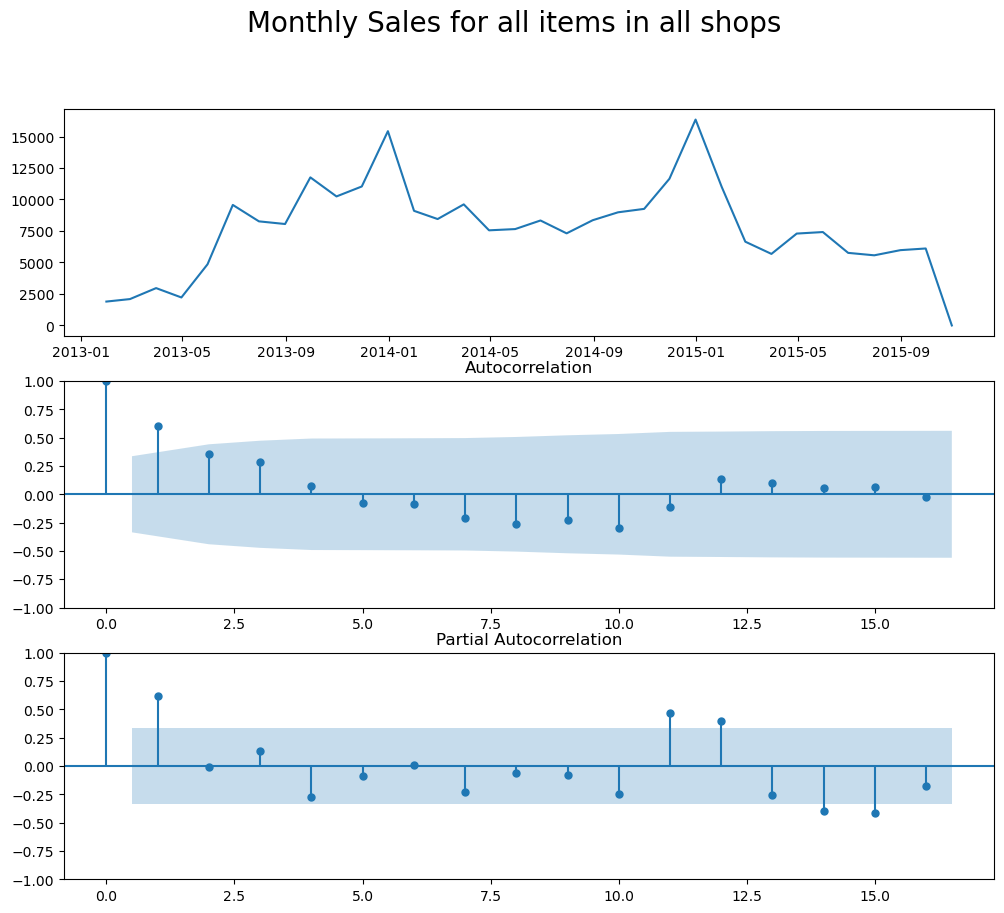

In [46]:
plot_ts_acf_pacf(y = y, title = "Monthly Sales for all items in all shops");

Nota importante: nos estamos ayudando del gráfico de acf y pacf, pero no vamos a entrenar un modelo ARIMA.

Para resolver el problema que se nos plantea: 299 Series Temporales diferentes tendríamos que entrenar 299 ARIMAs. En cambio, con el algoritmo de XGBoost podríamos entrenar 1 único modelo.

Ahora bien, al contrario que ARIMA (que internamente construye las variables necesarias), para XGBoost debemos ser explícitos y suministrarle todas y cada una de las variables necesarias.

Del gráfico anterior ya podemos observar que las variables de lags pueden ser muy relevantes.

IDEA para los alumnos: podéis intentar analizar algunas de las 299 Series Temporales de manera individual para ver su comportamiento.

<a id='eda_top_3_cities'></a>
### --> 2. EDA: Top 3 Cities
[Volver al índice](#index)<br>

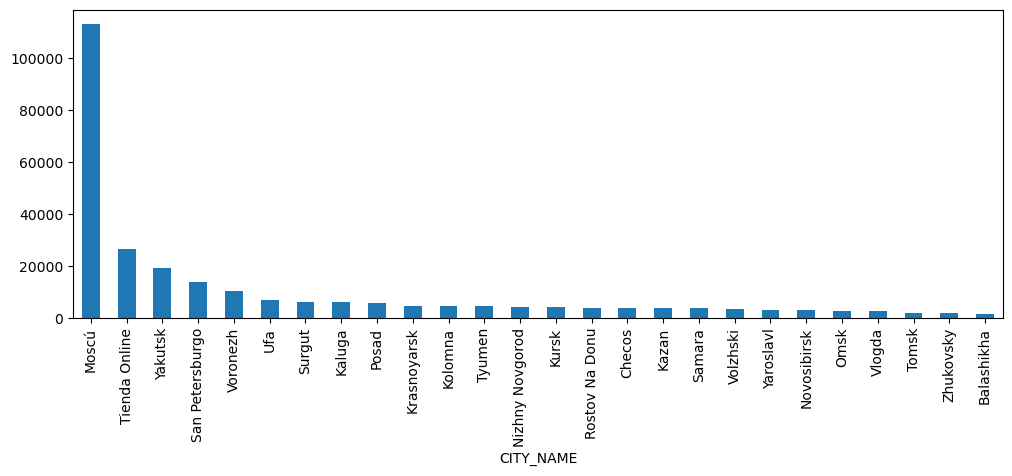

In [47]:
(
    full_df.groupby(["CITY_NAME"])
    ["MONTHLY_SALES"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

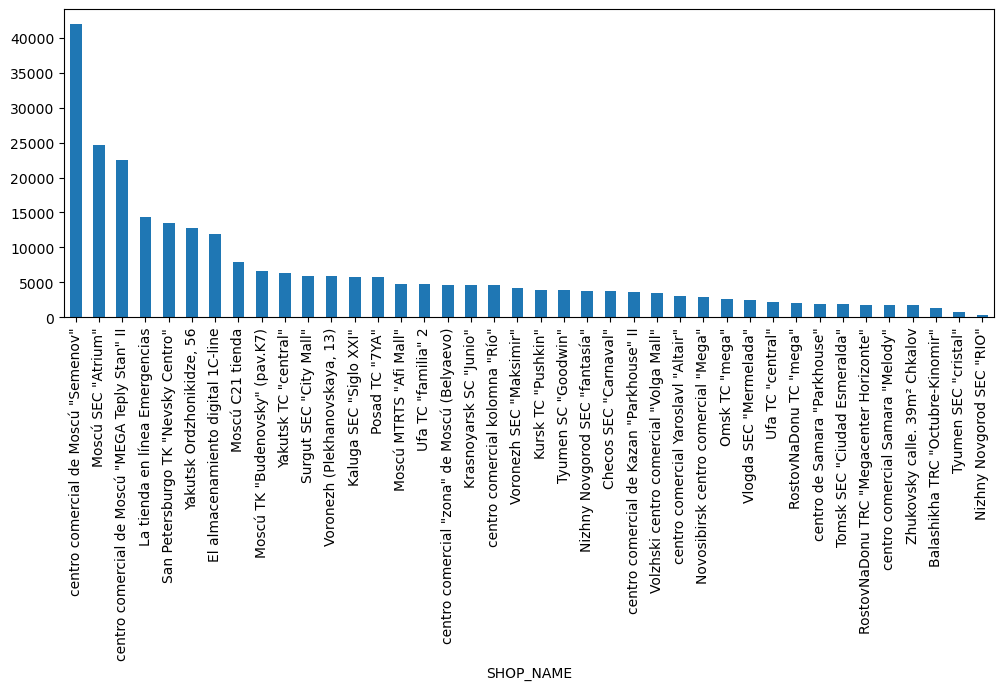

In [48]:
# Top tiendas
(
    full_df.groupby(["SHOP_NAME"])
    ["MONTHLY_SALES"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

<a id='eda_top_3_categories'></a>
### --> 3. EDA: Top 3 Categories
[Volver al índice](#index)<br>

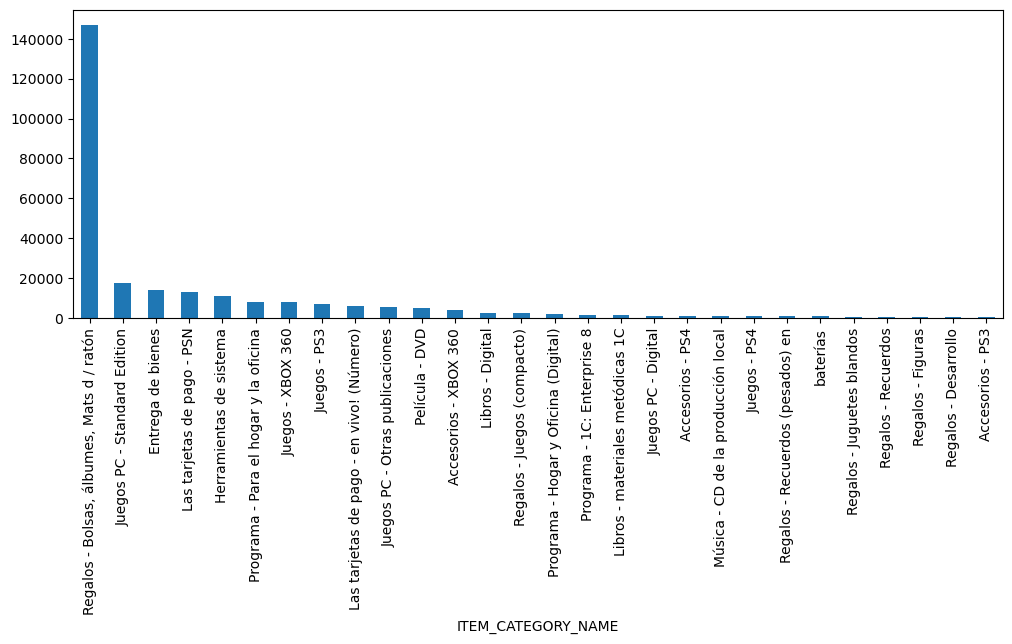

In [49]:
#top categorias
(
    full_df.
    groupby(["ITEM_CATEGORY_NAME"])
    ["MONTHLY_SALES"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

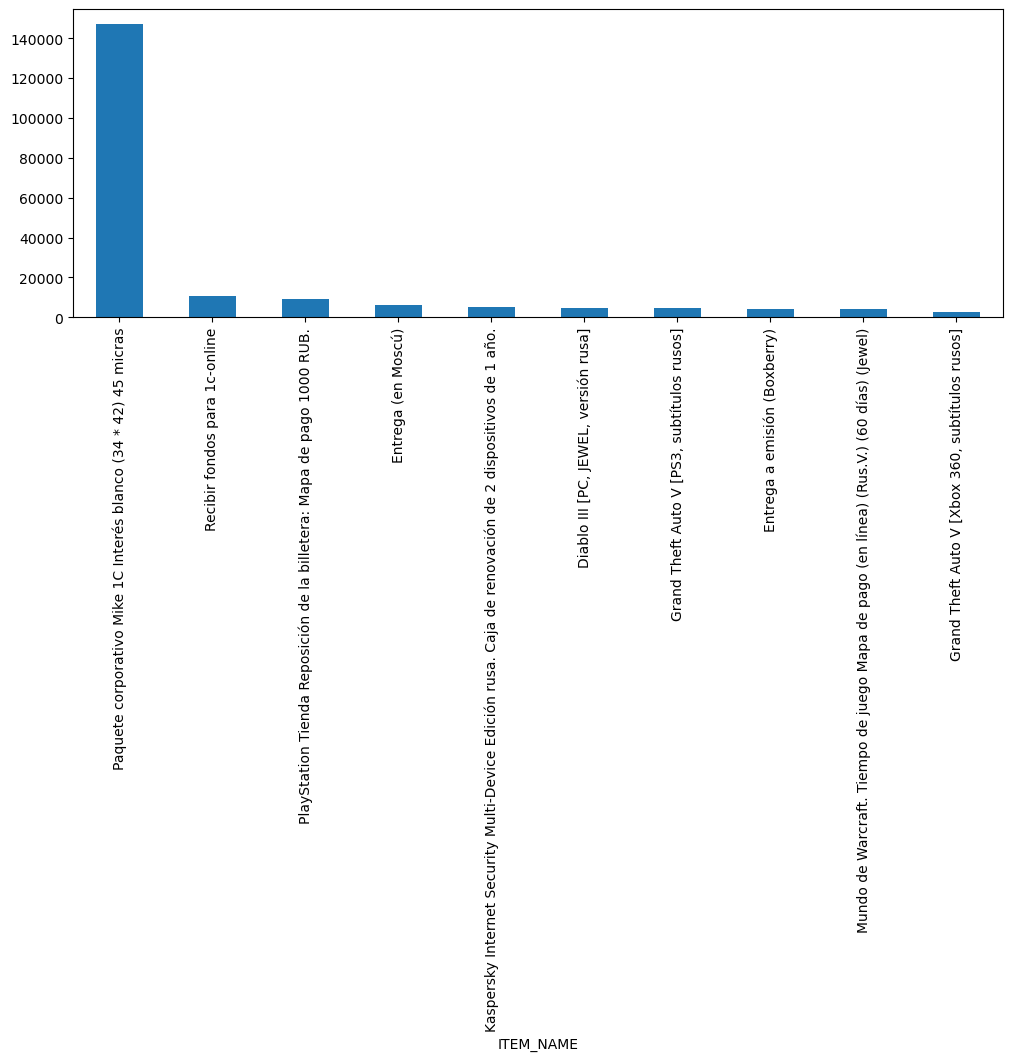

In [50]:
# Top Items
(
    full_df.
    groupby(["ITEM_NAME"])
    ["MONTHLY_SALES"].sum()
    .sort_values(ascending = False).head(10)
    .plot(kind = "bar", figsize = (12, 4))
);

<a id='build_ts_features'></a>
### Build Time Series Features (**CORE IDEA**)
[Volver al índice](#index)<br>

Dado que vamos a tener que iterar muchas veces sobre nuestro dataset, nos interesa tener todo encapsulado en funciones para su reutilización.

Uno de los apartados clave será la generación de variables.

Como hemos visto antes, nuestro dataset contiene 299 Series Temporales.

Algunas de estas Series Temporales las podemos agrupar para sacar nueva información.

Por ejemplo, podemos construir una variables del estilo:

1. Las ventas totales por ITEM_ID (la menor granularidad posible).
2. Las ventas totales por ITEM_CATEGORY_ID y SHOP_ID (una granularidad mayor a la 1).
3. Las ventas totales por SHOP_ID (una granularidad mayor).
4. Y todas las combinaciones que queramos intermedias.

In [51]:
full_df.sample(5).T

,4453,9901,1373,840,3444
DATE,2014-03-31 00:00:00,2015-10-31 00:00:00,2013-05-31 00:00:00,2013-03-31 00:00:00,2013-12-31 00:00:00
UNIQUE_ID,57-5380,21-17717,37-2808,55-492,31-4181
MONTHLY_SALES,6.0,0.0,11.0,0.0,41.0
MONTHLY_REVENUE,15345.0,0.0,10989.0,0.0,30709.5
UNIQUE_DAYS_WITH_SALES,6.0,0.0,11.0,0.0,21.0
TOTAL_TRANSACTIONS,6.0,0.0,11.0,0.0,21.0
MONTHLY_MEAN_PRICE,2557.5,1269.24359,999.0,600.0,782.673016
CITY_NAME,Yakutsk,Moscú,Novosibirsk,Tienda Online,Moscú
CITY_ID,23.0,7.0,9.0,16.0,7.0
SHOP_NAME,"Yakutsk Ordzhonikidze, 56","Moscú MTRTS ""Afi Mall""","Novosibirsk centro comercial ""Mega""",El almacenamiento digital 1C-line,"centro comercial de Moscú ""Semenov"""


In [52]:
full_df.sample(5)


,DATE,UNIQUE_ID,MONTHLY_SALES,MONTHLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,MONTHLY_MEAN_PRICE,CITY_NAME,CITY_ID,SHOP_NAME,SHOP_ID,ITEM_CATEGORY_NAME,ITEM_CATEGORY_ID,ITEM_NAME,ITEM_ID
9210,2015-07-31,55-3715,6.0,2514.0,3.0,3.0,479.0,Tienda Online,16.0,El almacenamiento digital 1C-line,55,Juegos PC - Digital,31,"Grand Theft Auto IV (Softklab) [PC, versión di...",3715
3851,2014-01-31,57-4181,36.0,39240.0,21.0,21.0,1090.0,Yakutsk,23.0,"Yakutsk Ordzhonikidze, 56",57,Programa - Para el hogar y la oficina,75,Kaspersky Internet Security Multi-Device Edici...,4181
1204,2013-05-31,14-20949,130.0,650.0,28.0,28.0,5.0,Kazan,3.0,"centro comercial de Kazan ""Parkhouse"" II",14,"Regalos - Bolsas, álbumes, Mats d / ratón",71,Paquete corporativo Mike 1C Interés blanco (34...,20949
8892,2015-06-30,50-4244,2.0,1299.0,2.0,2.0,649.5,Tyumen,18.0,"Tyumen SC ""Goodwin""",50,Juegos - XBOX 360,23,Kinect Rush [solo para Kinect] [Xbox 360],4244
1094,2013-04-30,44-22087,10.0,790.0,5.0,5.0,79.0,Samara,13.0,"centro comercial Samara ""Melody""",44,baterías,83,Elemento de potencia Duracell LR03-BC2,22087


Esta función toma un conjunto de datos completo (full_df), una lista de columnas de agrupación (gb_list), el nombre de la columna objetivo (target_column), una función de agregación (agg_func) y el nombre de la función de agregación (agg_func_name), y devuelve un DataFrame que contiene variables de serie de tiempo construidas a partir de las columnas especificadas.

In [53]:
def build_ts_vars(full_df, gb_list, target_column, agg_func, agg_func_name, verbose = True):
    
    assert gb_list[0] == "DATE", "First element must be date"
    
    new_name = "_".join(gb_list + [target_column] + [agg_func_name])
    
    if verbose: print(new_name)

    gb_df_ = full_df.groupby(gb_list)[target_column].apply(agg_func).to_frame().reset_index().rename(
        columns = {
            target_column : new_name
        }
    )

    gb_df_[f"{new_name}_LAG1"] = gb_df_.groupby(gb_list[1:])[new_name].transform(
        lambda series: series.shift(1)
    )
    
    return gb_df_

In [54]:
GB_LIST_SHOP_ID = ["DATE", "SHOP_ID"]
TARGET_COLUMN = "MONTHLY_SALES"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "SUM"

vars_ts_1 = build_ts_vars(
    full_df = full_df,
    gb_list = GB_LIST_SHOP_ID,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME
    
)

vars_ts_1.sample(10)

DATE_SHOP_ID_MONTHLY_SALES_SUM


,DATE,SHOP_ID,DATE_SHOP_ID_MONTHLY_SALES_SUM,DATE_SHOP_ID_MONTHLY_SALES_SUM_LAG1
370,2013-10-31,18,303.0,528.0
619,2014-04-30,34,0.0,0.0
971,2015-01-31,19,175.0,193.0
849,2014-10-31,16,168.0,161.0
451,2013-12-31,19,184.0,140.0
797,2014-08-31,57,349.0,346.0
904,2014-11-30,41,40.0,25.0
135,2013-04-30,25,257.0,517.0
652,2014-05-31,21,148.0,172.0
520,2014-02-28,3,23.0,26.0


In [55]:
#  ventas maximas de items 
GB_LIST_ITEM_MAX = ["DATE", "ITEM_ID"]
TARGET_COLUMN = "MONTHLY_SALES"
AGG_FUNC = np.max
AGG_FUNC_NAME = "MAX"

vars_ts_2 = build_ts_vars(
    full_df = full_df,
    gb_list = GB_LIST_ITEM_MAX,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME
    
)

vars_ts_2.sample(10)

DATE_ITEM_ID_MONTHLY_SALES_MAX


,DATE,ITEM_ID,DATE_ITEM_ID_MONTHLY_SALES_MAX,DATE_ITEM_ID_MONTHLY_SALES_MAX_LAG1
455,2013-05-31,7967,0.0,0.0
1650,2014-05-31,6740,3.0,6.0
2672,2015-03-31,13370,6.0,4.0
2917,2015-06-30,2753,3.0,8.0
3134,2015-08-31,4872,10.0,10.0
365,2013-04-30,11496,151.0,0.0
3077,2015-07-31,15063,1.0,2.0
66,2013-01-31,11921,0.0,NaN
3144,2015-08-31,6185,8.0,1.0
383,2013-04-30,16184,7.0,5.0


In [56]:
#  analizar la evolución de las ventas de artículos individuales, mes, mes anterior 
GB_LIST_ITEM_ID = ["DATE", "ITEM_ID"]
TARGET_COLUMN = "MONTHLY_SALES"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "SUM"

vars_ts_2_2 = build_ts_vars(
    full_df = full_df,
    gb_list = GB_LIST_ITEM_ID,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME
    
)

vars_ts_2_2.sample(10)

DATE_ITEM_ID_MONTHLY_SALES_SUM


,DATE,ITEM_ID,DATE_ITEM_ID_MONTHLY_SALES_SUM,DATE_ITEM_ID_MONTHLY_SALES_SUM_LAG1
2624,2015-03-31,3719,0.0,0.0
1512,2014-04-30,2252,8.0,7.0
2283,2014-11-30,16184,5.0,3.0
1961,2014-08-31,11365,5.0,6.0
156,2013-02-28,9355,0.0,0.0
2492,2015-01-31,21404,41.0,110.0
1960,2014-08-31,11272,13.0,14.0
992,2013-10-31,21404,0.0,0.0
823,2013-09-30,3715,13.0,7.0
3373,2015-10-31,13881,0.0,12.0


In [57]:
#Probaremos la variable a predecir pero con otras metricas: ingreso mensual ("MONTHLY_REVENUE") modifico a MIN

GB_LIST_ITEM_ID_rev = ["DATE", "ITEM_ID"]
TARGET_COLUMN = "MONTHLY_REVENUE"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "SUM"

vars_ts_3 = build_ts_vars(
    full_df = full_df,
    gb_list = GB_LIST_ITEM_ID_rev,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME
    
)

vars_ts_3.sample(10)

DATE_ITEM_ID_MONTHLY_REVENUE_SUM


,DATE,ITEM_ID,DATE_ITEM_ID_MONTHLY_REVENUE_SUM,DATE_ITEM_ID_MONTHLY_REVENUE_SUM_LAG1
306,2013-04-30,803,0.00,0.00
40,2013-01-31,5820,1999.00,NaN
287,2013-03-31,16790,0.00,0.00
1439,2014-03-31,5672,152680.00,233100.00
449,2013-05-31,6738,31454.50,67103.00
1603,2014-05-31,486,0.00,0.00
388,2013-04-30,17717,65781.00,145138.99
3060,2015-07-31,11272,1996.00,2994.00
2310,2014-12-31,1855,9588.00,7990.00
3230,2015-09-30,4181,151440.19,139626.11


In [58]:
# para analizar la evolución de las ventas de cada categoría de artículo
GB_LIST_SHOP_MEAN = ["DATE", "SHOP_ID"]
TARGET_COLUMN = "MONTHLY_SALES"
AGG_FUNC = np.mean
AGG_FUNC_NAME = "MEAN"

vars_ts_4 = build_ts_vars(
    full_df = full_df,
    gb_list = GB_LIST_SHOP_MEAN,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME
    
)

vars_ts_4.sample(10)

DATE_SHOP_ID_MONTHLY_SALES_MEAN


,DATE,SHOP_ID,DATE_SHOP_ID_MONTHLY_SALES_MEAN,DATE_SHOP_ID_MONTHLY_SALES_MEAN_LAG1
577,2014-03-31,28,28.076923,28.615385
604,2014-04-30,7,46.333333,40.666667
647,2014-05-31,14,27.666667,26.000000
1328,2015-10-31,15,0.000000,13.500000
1325,2015-10-31,11,0.000000,23.000000
124,2013-04-30,7,3.000000,3.000000
397,2013-10-31,57,26.863636,14.000000
859,2014-10-31,34,17.000000,26.000000
834,2014-09-30,53,35.000000,29.800000
1218,2015-07-31,31,15.471698,15.396226


In [59]:
#ITEM_CATEGORY_ID y SHOP_ID
GB_LIST_CAT_SHOP = ["DATE","ITEM_CATEGORY_ID", "SHOP_ID"]
TARGET_COLUMN = "MONTHLY_SALES"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "SUM"

vars_ts_6 = build_ts_vars(
    full_df = full_df,
    gb_list = GB_LIST_CAT_SHOP,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME
    
)

vars_ts_6.sample(10)

DATE_ITEM_CATEGORY_ID_SHOP_ID_MONTHLY_SALES_SUM


,DATE,ITEM_CATEGORY_ID,SHOP_ID,DATE_ITEM_CATEGORY_ID_SHOP_ID_MONTHLY_SALES_SUM,DATE_ITEM_CATEGORY_ID_SHOP_ID_MONTHLY_SALES_SUM_LAG1
1922,2013-11-30,75,16,13.0,19.0
1689,2013-10-31,55,28,10.0,11.0
5630,2015-08-31,71,26,78.0,42.0
2102,2013-12-31,75,22,40.0,35.0
4141,2014-12-31,30,31,159.0,170.0
17,2013-01-31,19,31,14.0,NaN
5579,2015-08-31,35,14,10.0,5.0
505,2013-03-31,75,58,0.0,0.0
2526,2014-03-31,28,25,14.0,21.0
5988,2015-10-31,71,31,0.0,473.0


In [60]:
# # CATEGORIA Y PRODUCTO
GB_LIST_CAT_CITY = ["DATE","ITEM_CATEGORY_ID", "CITY_ID"]
TARGET_COLUMN = "MONTHLY_SALES"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "SUM"

vars_ts_7 = build_ts_vars(
    full_df = full_df,
    gb_list = GB_LIST_CAT_CITY,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME
    
)

vars_ts_7.sample(10)

DATE_ITEM_CATEGORY_ID_CITY_ID_MONTHLY_SALES_SUM


,DATE,ITEM_CATEGORY_ID,CITY_ID,DATE_ITEM_CATEGORY_ID_CITY_ID_MONTHLY_SALES_SUM,DATE_ITEM_CATEGORY_ID_CITY_ID_MONTHLY_SALES_SUM_LAG1
881,2013-08-31,19,18.0,39.0,61.0
3591,2015-05-31,79,20.0,8.0,13.0
1044,2013-09-30,35,19.0,8.0,2.0
607,2013-05-31,79,7.0,15.0,25.0
1395,2013-12-31,30,9.0,6.0,4.0
2715,2014-10-31,79,7.0,289.0,263.0
2229,2014-06-30,79,22.0,24.0,22.0
1685,2014-02-28,71,7.0,2215.0,2251.0
774,2013-07-31,30,7.0,588.0,574.0
1715,2014-02-28,75,25.0,21.0,21.0


**RESOLVIENDO PREGUNTAS DEL CUESTIONARIO:**


1. ¿Cuáles han sido las ventas totales en la ciudad de Yaroslavl durante el año 2014?

In [61]:
# OK,  (Mejorar: Como podria sacar este resultado sin crear df o solo el año concreto?)
full_df_2014 = full_df[full_df["CITY_NAME"] == "Yaroslavl"]
full_df_2014 = full_df_2014.set_index("DATE").resample("Y")["MONTHLY_SALES"].sum().to_frame().reset_index()
full_df_2014

,DATE,MONTHLY_SALES
0,2013-12-31,1100.0
1,2014-12-31,1281.0
2,2015-12-31,656.0


2. La tercera ciudad con más ventas (durante todo el periodo) es:

In [62]:
# OK
full_df.groupby(["CITY_NAME"])["MONTHLY_SALES"].sum().sort_values(ascending = False).head(3)

CITY_NAME
Moscú            112899.0
Tienda Online     26338.0
Yakutsk           19016.0
Name: MONTHLY_SALES, dtype: float64

In [63]:
resultados = full_df.groupby(["CITY_NAME"])["MONTHLY_SALES"].sum().sort_values(ascending = False)
tercer_resultado = resultados.iloc[2]
print(tercer_resultado)

19016.0


3. El item_name mas caro del año 2013 es:

In [64]:
#ok
df_2013= df[df['DATE'].dt.year == 2013].sort_values(by='ITEM_PRICE', ascending=False)
df_2013.iloc[0][['ITEM_NAME', 'ITEM_PRICE']]

ITEM_NAME     Entrega (EMS)
ITEM_PRICE          59200.0
Name: 15432, dtype: object

4. La media móvil de 3 meses para la tienda centro de Samara "Parkhouse" a fecha 2013-03-31 (incluyendo el mes) es:

In [65]:
# Seleccionar los datos correspondientes a la tienda y el periodo deseado
df_parkhouse = df[(df['SHOP_NAME'] == 'centro de Samara "Parkhouse"') & (df['DATE'] <= '2013-03-31')]

# Convertir la columna DATE en un índice de tipo datetime
df_parkhouse.set_index(pd.to_datetime(df_parkhouse['DATE']), inplace=True)

# Calcular el total de ventas por mes
monthly_sales = df_parkhouse['SALES'].resample('M').sum()

# Calcular el promedio de ventas para periodos de 3 meses
rolling_mean = monthly_sales.rolling(window=3).sum() / 3

# Seleccionar el último valor de la media móvil para el mes deseado
filtered_mean = rolling_mean.loc['2013-03-31']
print(f"La media móvil de 3 meses para la tienda centro de Samara 'Parkhouse' a fecha 2013-03-31 (incluyendo el mes) es: {filtered_mean:.2f}")

La media móvil de 3 meses para la tienda centro de Samara 'Parkhouse' a fecha 2013-03-31 (incluyendo el mes) es: 23.67


5. La segunda categoría más vendida durante el año 2014 ha sido:

In [66]:
# OK
df_2014= df[df['DATE'].dt.year == 2014]
df_2014.groupby(['ITEM_CATEGORY_NAME'])["SALES"].agg(sum).sort_values(ascending=False).head(2)


ITEM_CATEGORY_NAME
Regalos - Bolsas, álbumes, Mats d / ratón    65929.0
Entrega de bienes                             5952.0
Name: SALES, dtype: float64

6. El día con más ventas de todo el periodo corresponde a:


In [67]:
#OK
df.set_index("DATE").resample("D")["SALES"].sum().to_frame().reset_index().sort_values(by= "SALES",ascending=False).head(2)

,DATE,SALES
868,2015-05-19,1524.0
728,2014-12-30,1430.0


7. La primera media móvil de 7 días (después de hacer dropna) corresponde a:

In [68]:
# Agrupar las ventas por día y sumar las ventas
daily_sales = df.groupby('DATE')['SALES'].sum()

# Calcular la media móvil de 7 días
rolling_mean = daily_sales.dropna().rolling(window=7).mean()

# Seleccionar la primera media móvil de 7 días
first_rolling_mean = rolling_mean[6]

# Obtener la fecha correspondiente a la primera media móvil de 7 días
first_date = rolling_mean.index[6].strftime('%Y-%m-%d')
print(f"La primera media móvil de 7 días después de hacer dropna es: {first_rolling_mean} y corresponde al día {first_date}")

La primera media móvil de 7 días después de hacer dropna es: 71.71428571428571 y corresponde al día 2013-01-07


8. El item_id que menos días distintos se ha vendido es

In [69]:
# Ok
df.groupby('ITEM_ID')['DATE'].nunique().reset_index().sort_values('DATE', ascending=True).iloc[0]

ITEM_ID    15256
DATE         165
Name: 79, dtype: int64

9. La ciudad que más tiendas tiene es:

In [70]:
#ok
full_df.groupby('CITY_NAME')['SHOP_NAME'].nunique().reset_index().sort_values('SHOP_NAME', ascending=False).iloc[0]

CITY_NAME    Moscú
SHOP_NAME        7
Name: 7, dtype: object

10. El item_category_id que más se vende en la ciudad de Surgut es

In [71]:
full_df_surgut= full_df[full_df['CITY_NAME'] == 'Surgut']
full_df_surgut.groupby(['ITEM_CATEGORY_ID'])["MONTHLY_SALES"].agg(sum).sort_values(ascending=False).head(1)

ITEM_CATEGORY_ID
71    4365.0
Name: MONTHLY_SALES, dtype: float64

In [72]:
# Limpiamos: Borramos las nuevas variables que hemos creado para poder responder las preguntas anteriores, solicitadas:
del full_df_2014,resultados,tercer_resultado,df_2013, df_parkhouse,monthly_sales,filtered_mean,df_2014,daily_sales, rolling_mean, first_rolling_mean, first_date, full_df_surgut


<a id='join_ts_features'></a>
### Join TS Features
[Volver al índice](#index)<br>

In [73]:
rows_before_merge = full_df.shape[0]
print(f"Shape before merge is {rows_before_merge}")

full_df = pd.merge(full_df, vars_ts_1, on = GB_LIST_SHOP_ID, how = "left")
full_df = pd.merge(full_df, vars_ts_2, on = GB_LIST_ITEM_MAX, how = "left")
full_df = pd.merge(full_df, vars_ts_2_2, on = GB_LIST_ITEM_ID, how = "left")
full_df = pd.merge(full_df, vars_ts_3, on = GB_LIST_ITEM_ID_rev, how = "left")
full_df = pd.merge(full_df, vars_ts_4, on = GB_LIST_SHOP_MEAN, how = "left")
full_df = pd.merge(full_df, vars_ts_6, on = GB_LIST_CAT_SHOP, how = "left")
full_df = pd.merge(full_df, vars_ts_7, on = GB_LIST_CAT_CITY, how = "left")


rows_after_merge = full_df.shape[0]

print(f"Shape after merge is {rows_after_merge}")

assert rows_before_merge == rows_after_merge, "You have generated a cartesian product!"

Shape before merge is 10166
Shape after merge is 10166


In [74]:
full_df.to_pickle("FULL_DF_ALL_FEATURES.pkl")

<a id='train_test_split'></a>
### Train Test Split
[Volver al índice](#index)<br>

In [75]:
full_df = pd.read_pickle("FULL_DF_ALL_FEATURES.pkl")

In [76]:
full_df.head(3)

,DATE,UNIQUE_ID,MONTHLY_SALES,MONTHLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,MONTHLY_MEAN_PRICE,CITY_NAME,CITY_ID,SHOP_NAME,...,DATE_ITEM_ID_MONTHLY_SALES_SUM,DATE_ITEM_ID_MONTHLY_SALES_SUM_LAG1,DATE_ITEM_ID_MONTHLY_REVENUE_SUM,DATE_ITEM_ID_MONTHLY_REVENUE_SUM_LAG1,DATE_SHOP_ID_MONTHLY_SALES_MEAN,DATE_SHOP_ID_MONTHLY_SALES_MEAN_LAG1,DATE_ITEM_CATEGORY_ID_SHOP_ID_MONTHLY_SALES_SUM,DATE_ITEM_CATEGORY_ID_SHOP_ID_MONTHLY_SALES_SUM_LAG1,DATE_ITEM_CATEGORY_ID_CITY_ID_MONTHLY_SALES_SUM,DATE_ITEM_CATEGORY_ID_CITY_ID_MONTHLY_SALES_SUM_LAG1
0,2013-01-31,11-20949,0.0,0.0,0.0,0.0,3.000000,Zhukovsky,25.0,Zhukovsky calle. 39m² Chkalov,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
1,2013-01-31,11-4181,0.0,0.0,0.0,0.0,707.000000,Zhukovsky,25.0,Zhukovsky calle. 39m² Chkalov,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
2,2013-01-31,12-11365,35.0,43300.0,12.0,12.0,1511.512626,Tienda Online,16.0,La tienda en línea Emergencias,...,35.0,NaN,43300.0,NaN,32.8,NaN,145.0,NaN,145.0,NaN


In [77]:
# (4000 - 15) ** 2

In [78]:
np.clip([30, 400, 10], 0, 30)

array([30, 30, 10])

In [79]:
# explicar en clase el motivo del np.clip con el RMSE
full_df["MONTHLY_SALES"] = np.clip(full_df["MONTHLY_SALES"], 0, 30)

In [80]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10166 entries, 0 to 10165
Data columns (total 29 columns):
 #   Column                                                Non-Null Count  Dtype         
---  ------                                                --------------  -----         
 0   DATE                                                  10166 non-null  datetime64[ns]
 1   UNIQUE_ID                                             10166 non-null  object        
 2   MONTHLY_SALES                                         10166 non-null  float64       
 3   MONTHLY_REVENUE                                       10166 non-null  float64       
 4   UNIQUE_DAYS_WITH_SALES                                10166 non-null  float64       
 5   TOTAL_TRANSACTIONS                                    10166 non-null  float64       
 6   MONTHLY_MEAN_PRICE                                    10166 non-null  float64       
 7   CITY_NAME                                             10166 non-null  object

In [81]:
full_df.columns.to_list()

['DATE',
 'UNIQUE_ID',
 'MONTHLY_SALES',
 'MONTHLY_REVENUE',
 'UNIQUE_DAYS_WITH_SALES',
 'TOTAL_TRANSACTIONS',
 'MONTHLY_MEAN_PRICE',
 'CITY_NAME',
 'CITY_ID',
 'SHOP_NAME',
 'SHOP_ID',
 'ITEM_CATEGORY_NAME',
 'ITEM_CATEGORY_ID',
 'ITEM_NAME',
 'ITEM_ID',
 'DATE_SHOP_ID_MONTHLY_SALES_SUM',
 'DATE_SHOP_ID_MONTHLY_SALES_SUM_LAG1',
 'DATE_ITEM_ID_MONTHLY_SALES_MAX',
 'DATE_ITEM_ID_MONTHLY_SALES_MAX_LAG1',
 'DATE_ITEM_ID_MONTHLY_SALES_SUM',
 'DATE_ITEM_ID_MONTHLY_SALES_SUM_LAG1',
 'DATE_ITEM_ID_MONTHLY_REVENUE_SUM',
 'DATE_ITEM_ID_MONTHLY_REVENUE_SUM_LAG1',
 'DATE_SHOP_ID_MONTHLY_SALES_MEAN',
 'DATE_SHOP_ID_MONTHLY_SALES_MEAN_LAG1',
 'DATE_ITEM_CATEGORY_ID_SHOP_ID_MONTHLY_SALES_SUM',
 'DATE_ITEM_CATEGORY_ID_SHOP_ID_MONTHLY_SALES_SUM_LAG1',
 'DATE_ITEM_CATEGORY_ID_CITY_ID_MONTHLY_SALES_SUM',
 'DATE_ITEM_CATEGORY_ID_CITY_ID_MONTHLY_SALES_SUM_LAG1']

In [82]:
COLUMNS_TO_DROP = [
    'MONTHLY_REVENUE',
    'UNIQUE_DAYS_WITH_SALES',
    'TOTAL_TRANSACTIONS',
    'MONTHLY_MEAN_PRICE',
    'CITY_NAME',
    'SHOP_NAME',
    'ITEM_CATEGORY_NAME',
    'ITEM_NAME',
    
    'DATE_SHOP_ID_MONTHLY_SALES_SUM',
#     'DATE_SHOP_ID_MONTHLY_SALES_MIN',
    'DATE_ITEM_ID_MONTHLY_SALES_MAX',
    'DATE_ITEM_ID_MONTHLY_SALES_SUM',
    'DATE_ITEM_ID_MONTHLY_REVENUE_SUM',
    'DATE_SHOP_ID_MONTHLY_SALES_MEAN',
    'DATE_ITEM_CATEGORY_ID_SHOP_ID_MONTHLY_SALES_SUM',
    'DATE_ITEM_CATEGORY_ID_CITY_ID_MONTHLY_SALES_SUM',

]

full_df.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [83]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10166 entries, 0 to 10165
Data columns (total 14 columns):
 #   Column                                                Non-Null Count  Dtype         
---  ------                                                --------------  -----         
 0   DATE                                                  10166 non-null  datetime64[ns]
 1   UNIQUE_ID                                             10166 non-null  object        
 2   MONTHLY_SALES                                         10166 non-null  float64       
 3   CITY_ID                                               10166 non-null  float64       
 4   SHOP_ID                                               10166 non-null  int64         
 5   ITEM_CATEGORY_ID                                      10166 non-null  int64         
 6   ITEM_ID                                               10166 non-null  int64         
 7   DATE_SHOP_ID_MONTHLY_SALES_SUM_LAG1                   9867 non-null   float6

In [84]:
full_df["DATE_SHOP_ID_MONTHLY_SALES_SUM_LAG1"].fillna(0, inplace = True)

full_df["DATE_ITEM_ID_MONTHLY_SALES_MAX_LAG1"].fillna(0, inplace = True)
full_df["DATE_ITEM_ID_MONTHLY_SALES_SUM_LAG1"].fillna(0, inplace = True)
full_df["DATE_ITEM_ID_MONTHLY_REVENUE_SUM_LAG1"].fillna(0, inplace = True)
full_df["DATE_ITEM_CATEGORY_ID_SHOP_ID_MONTHLY_SALES_SUM_LAG1"].fillna(0, inplace = True)
full_df["DATE_ITEM_CATEGORY_ID_CITY_ID_MONTHLY_SALES_SUM_LAG1"].fillna(0, inplace = True)

In [85]:
full_df.set_index("UNIQUE_ID", inplace = True)

In [86]:
full_df.sample(5)

,DATE,MONTHLY_SALES,CITY_ID,SHOP_ID,ITEM_CATEGORY_ID,ITEM_ID,DATE_SHOP_ID_MONTHLY_SALES_SUM_LAG1,DATE_ITEM_ID_MONTHLY_SALES_MAX_LAG1,DATE_ITEM_ID_MONTHLY_SALES_SUM_LAG1,DATE_ITEM_ID_MONTHLY_REVENUE_SUM_LAG1,DATE_SHOP_ID_MONTHLY_SALES_MEAN_LAG1,DATE_ITEM_CATEGORY_ID_SHOP_ID_MONTHLY_SALES_SUM_LAG1,DATE_ITEM_CATEGORY_ID_CITY_ID_MONTHLY_SALES_SUM_LAG1
UNIQUE_ID,,,,,,,,,,,,,
25-3851,2014-10-31,8.0,7.0,25,19,3851,723.0,5.0,8.0,7192.0,24.931034,10.0,78.0
52-5822,2015-01-31,6.0,19.0,52,35,5822,92.0,77.0,491.0,513799.1,46.000000,9.0,9.0
58-6497,2013-05-31,1.0,23.0,58,28,6497,25.0,0.0,0.0,0.0,2.083333,0.0,13.0
57-7856,2014-08-31,9.0,23.0,57,28,7856,346.0,17.0,107.0,85332.5,15.727273,7.0,21.0
58-14227,2015-04-30,17.0,23.0,58,30,14227,156.0,29.0,47.0,4653.0,13.000000,49.0,107.0


SPLIT TRAIN, TEST, VALIDATION

In [87]:
train_index = sorted(list(full_df["DATE"].unique()))[:-2]

valida_index = [sorted(list(full_df["DATE"].unique()))[-2]]

test_index = [sorted(list(full_df["DATE"].unique()))[-1]]

In [88]:
X_train = full_df[full_df["DATE"].isin(train_index)].drop(['MONTHLY_SALES', "DATE"], axis=1)
Y_train = full_df[full_df["DATE"].isin(train_index)]['MONTHLY_SALES']

X_valida = full_df[full_df["DATE"].isin(valida_index)].drop(['MONTHLY_SALES', "DATE"], axis=1)
Y_valida = full_df[full_df["DATE"].isin(valida_index)]['MONTHLY_SALES']

X_test = full_df[full_df["DATE"].isin(test_index)].drop(['MONTHLY_SALES', "DATE"], axis = 1)
Y_test = full_df[full_df["DATE"].isin(test_index)]['MONTHLY_SALES']

In [89]:
X_train.head(3)

,CITY_ID,SHOP_ID,ITEM_CATEGORY_ID,ITEM_ID,DATE_SHOP_ID_MONTHLY_SALES_SUM_LAG1,DATE_ITEM_ID_MONTHLY_SALES_MAX_LAG1,DATE_ITEM_ID_MONTHLY_SALES_SUM_LAG1,DATE_ITEM_ID_MONTHLY_REVENUE_SUM_LAG1,DATE_SHOP_ID_MONTHLY_SALES_MEAN_LAG1,DATE_ITEM_CATEGORY_ID_SHOP_ID_MONTHLY_SALES_SUM_LAG1,DATE_ITEM_CATEGORY_ID_CITY_ID_MONTHLY_SALES_SUM_LAG1
UNIQUE_ID,,,,,,,,,,,
11-20949,25.0,11,71,20949,0.0,0.0,0.0,0.0,NaN,0.0,0.0
11-4181,25.0,11,75,4181,0.0,0.0,0.0,0.0,NaN,0.0,0.0
12-11365,16.0,12,9,11365,0.0,0.0,0.0,0.0,NaN,0.0,0.0


<a id='model_train'></a>
### Model Train
[Volver al índice](#index)<br>

Entrenamos nuestro modelo de Machine Learning (benchmark).

In [90]:
model = xgb.XGBRegressor(eval_metric = "rmse", early_stopping_rounds = 10, seed = 175)
# model = xgb.XGBRegressor(eval_metric = "rmse", seed = 175)

model_name = str(model).split("(")[0]

day = str(datetime.now()).split()[0].replace("-", "_")
hour = str(datetime.now()).split()[1].replace(":", "_").split(".")[0]
t = str(day) + "_" + str(hour)

model.fit(X_train, Y_train, 
    eval_set = [(X_train, Y_train), (X_valida, Y_valida)], 
    verbose = True)

[0]	validation_0-rmse:11.55300	validation_1-rmse:10.15825
[1]	validation_0-rmse:9.07372	validation_1-rmse:7.79966
[2]	validation_0-rmse:7.52864	validation_1-rmse:6.39210
[3]	validation_0-rmse:6.56671	validation_1-rmse:5.58493
[4]	validation_0-rmse:6.01084	validation_1-rmse:5.16823
[5]	validation_0-rmse:5.68692	validation_1-rmse:4.89330
[6]	validation_0-rmse:5.48014	validation_1-rmse:4.77967
[7]	validation_0-rmse:5.34194	validation_1-rmse:4.72329
[8]	validation_0-rmse:5.23928	validation_1-rmse:4.65765
[9]	validation_0-rmse:5.15629	validation_1-rmse:4.66156
[10]	validation_0-rmse:5.08941	validation_1-rmse:4.67009
[11]	validation_0-rmse:5.03727	validation_1-rmse:4.66363
[12]	validation_0-rmse:5.00018	validation_1-rmse:4.65423
[13]	validation_0-rmse:4.95062	validation_1-rmse:4.65996
[14]	validation_0-rmse:4.88423	validation_1-rmse:4.65318
[15]	validation_0-rmse:4.83532	validation_1-rmse:4.63687
[16]	validation_0-rmse:4.77498	validation_1-rmse:4.63594
[17]	validation_0-rmse:4.72967	validati

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=10, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=175,
             reg_alpha=0, reg_lambda=1, ...)

In [91]:
pickle.dump(model, open("{}_{}.dat".format(model_name, t), "wb"))
print("{}_{}.dat".format(model_name, t))

XGBRegressor_2023_05_03_21_04_34.dat


<a id='model_evaluation'></a>
### Model Evaluation (**CORE IDEA**)
[Volver al índice](#index)<br>

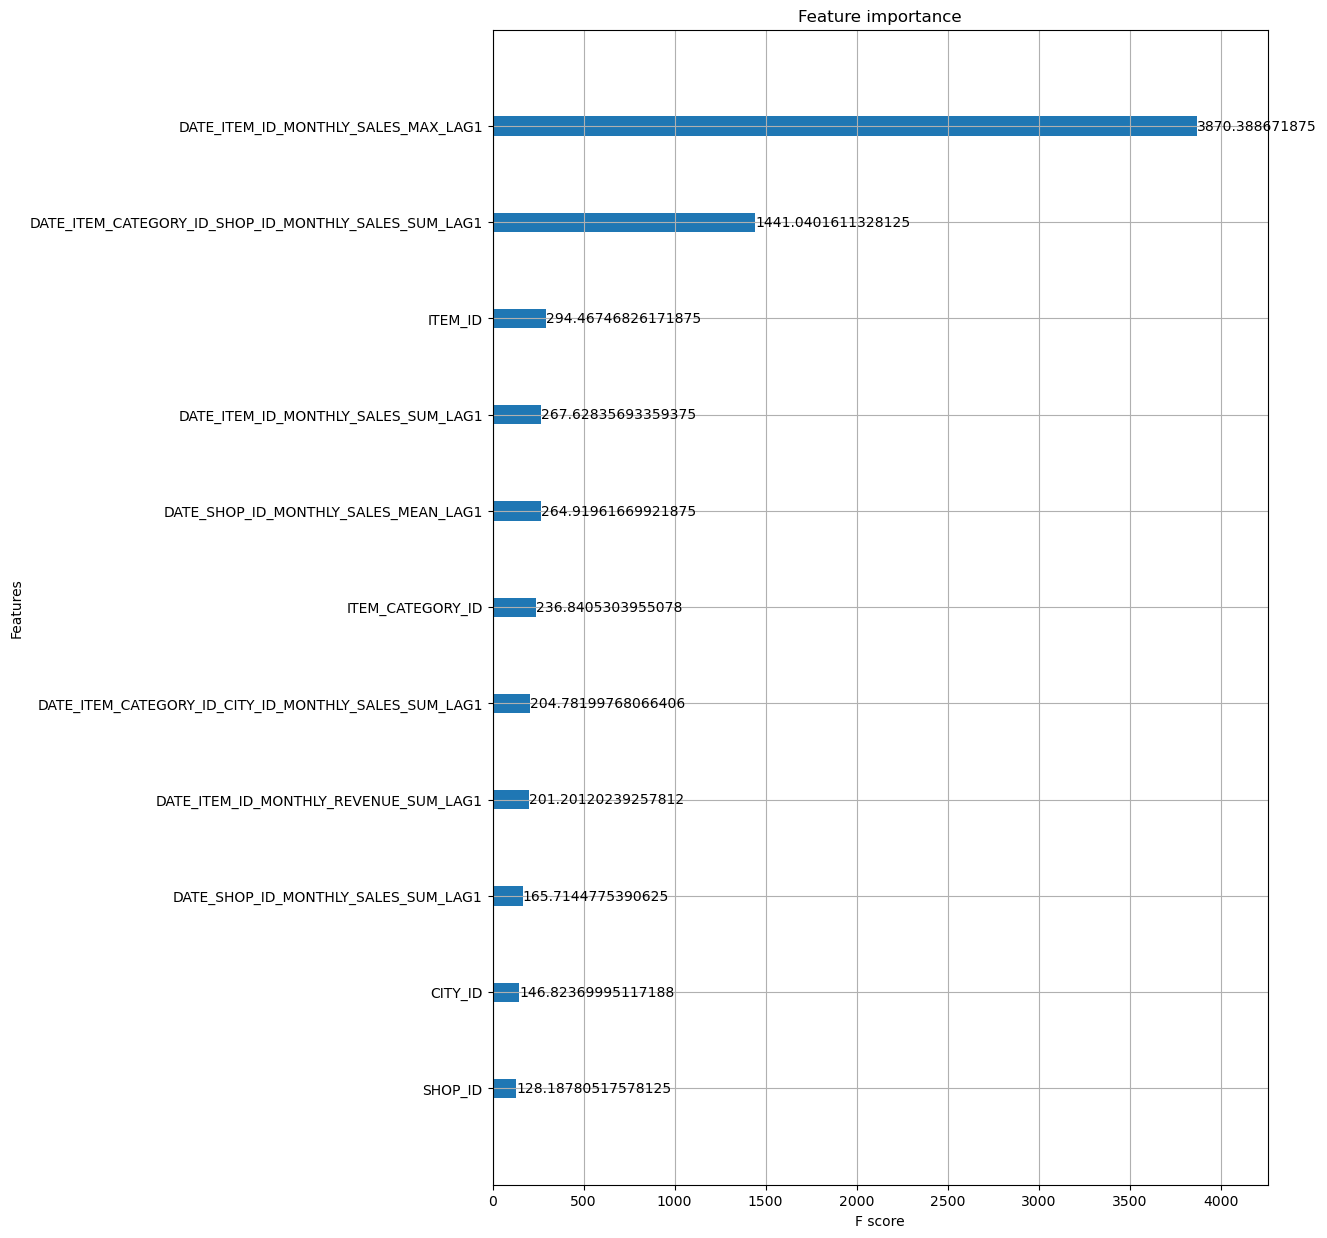

In [92]:
importance = model.get_booster().get_score(importance_type = "gain")
importance = {k: v for k, v in sorted(importance.items(), key = lambda item: item[1])}

fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(model, importance_type = "gain", ax = ax);

<a id='prediction'></a>
### Prediction
[Volver al índice](#index)<br>

En este apartado vamos a utilizar el modelo entrenado para hacer una predicción y posteriormente enviar el submit a Kaggle.

In [93]:
last_trained_model = pickle.load(open("{}_{}.dat".format(model_name, t), "rb"))

In [94]:
Y_valida_pred = model.predict(X_valida)

rmse_valida = np.sqrt(mean_squared_error(Y_valida, Y_valida_pred))
rmse_valida

4.571672546315195

In [95]:
if "SALES_PREDICTED" in X_test.columns:
    X_test.drop("SALES_PREDICTED", axis = 1, inplace = True)
    
Y_test_predict = model.predict(X_test)
X_test["SALES_PREDICTED"] = np.clip(Y_test_predict, 0, 30)

In [96]:
X_test["SALES_PREDICTED"]

UNIQUE_ID
11-20949    25.151295
11-4181      8.046409
12-11365    11.946606
12-11369    29.718981
12-11370    28.695301
              ...    
6-5823      10.352370
6-7856       3.151070
7-17717     16.094830
7-20949     27.728676
7-5822       8.084702
Name: SALES_PREDICTED, Length: 299, dtype: float32

In [97]:
X_test.reset_index(inplace = True)

In [98]:
X_test.head(3)

,UNIQUE_ID,CITY_ID,SHOP_ID,ITEM_CATEGORY_ID,ITEM_ID,DATE_SHOP_ID_MONTHLY_SALES_SUM_LAG1,DATE_ITEM_ID_MONTHLY_SALES_MAX_LAG1,DATE_ITEM_ID_MONTHLY_SALES_SUM_LAG1,DATE_ITEM_ID_MONTHLY_REVENUE_SUM_LAG1,DATE_SHOP_ID_MONTHLY_SALES_MEAN_LAG1,DATE_ITEM_CATEGORY_ID_SHOP_ID_MONTHLY_SALES_SUM_LAG1,DATE_ITEM_CATEGORY_ID_CITY_ID_MONTHLY_SALES_SUM_LAG1,SALES_PREDICTED
0,11-20949,25.0,11,71,20949,46.0,473.0,3342.0,16670.59,23.0,37.0,37.0,25.151295
1,11-4181,25.0,11,75,4181,46.0,17.0,122.0,151440.19,23.0,9.0,9.0,8.046409
2,12-11365,16.0,12,9,11365,607.0,21.0,21.0,17320.00,121.4,600.0,600.0,11.946606


In [99]:
Y_train_predict = model.predict(X_train)
Y_valida_predict = model.predict(X_valida)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

In [100]:
rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

In [101]:
rmse_train= str(round(rmse_train, 5)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 5)).replace(".", "_")

In [102]:
(
    X_test[["UNIQUE_ID", "SALES_PREDICTED"]]
    .rename(columns = {"UNIQUE_ID":"unique_id", "SALES_PREDICTED":"sales"})
    .to_csv(f"submission_train_{rmse_train}_valida_{rmse_valida}.csv", index = False)
)

<a id='conclusion'></a>
### Conclusión
[Volver al índice](#index)<br>

En este notebook hemos explorado la importancia en Machine Learning de utilizar un modelo benchmark cuando nos enfrentamos por primera vez a un nuevo dataset.

Establecer el benchmark nos ayuda a entender cual es el punto de partida.

Al entrenar un modelo, tenemos ya un notebook funcional que nos permite entrar en la siguiente loop:

1. Hacer un poco más de EDA.
2. Construir nuevas variables.
3. Probar estas variables en el modelo.
4. Guardar el score para ver la mejora o no (Kaggle Submit).
5. Volver al punto 1.

A continuación dejamos algunas ideas que los alumnos pueden implementar para mejorar el benchmark:

1. Probad otras combinaciones de variables.
2. Darle más profundidad a los lags/shifts.
3. Implementar medias móviles (ojo variables autoexplicativas).
4. Utilizar otras columnas en vez de MONTHLY_SALES para construir las variables.
5. Añadir variables externas (relación rublo/dólar, festivos locales etc).
6. Probar otros algoritmos.
7. Tunnear los hiperparametros del modelo.

### Happy Kaggling :)

<a id='referencias'></a>
### Referencias y lecturas recomendables
[Volver al índice](#index)<br>

A continuación dejamos algunos links útiles para profundizar en algunos de los conceptos que hemos visto en el notebook:

[The importance of Benchmarking](https://blog.bigml.com/2020/03/20/machine-learning-benchmarking-youre-doing-it-wrong/)

[Tree Based Models and Extrapolation (MUY RECOMENDABLE)](https://shanminlin.medium.com/how-to-help-tree-based-models-extrapolate-7954287b1219)

[XGBoost](https://xgboost.readthedocs.io/en/stable/)